In [1]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

from mne.viz import plot_compare_evokeds

import numpy as np 

import os 
from andante_pd_ft2mne import import2mne  

Idea : perform bandpass filtering for alpha and beta bands, separately, followed by Hilbert Transform, and remove evoked component, to yield single trial power estimates. Then, analyze temporal generalization on this. 

[link](https://martinos.org/mne/stable/auto_examples/time_frequency/plot_time_frequency_global_field_power.html#sphx-glr-auto-examples-time-frequency-plot-time-frequency-global-field-power-py)


Could be also done on Morlet wavelet, but it should not change much. 

Here is a comparison using MNE of [Morlet vs TFR vs Stockwell](https://www.martinos.org/mne/stable/auto_examples/time_frequency/plot_time_frequency_simulated.html#sphx-glr-auto-examples-time-frequency-plot-time-frequency-simulated-py) 

Defining methods
--

In [2]:
datadir = '/home/nfarrugi/localdata/mpi_pd_cueing/data_ica_cleaned/'
resultdir = '/home/nfarrugi/localdata/mpi_pd_cueing/results_beta/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

In [3]:
from scipy.stats import mannwhitneyu

def mann_witt_matrix(mat,y):
    lcol = mat.shape[1]
    pvalue = np.zeros((lcol,lcol))
    statU = np.zeros((lcol,lcol))
    probav = np.zeros((2,lcol,lcol))
    unik = (np.unique(y))
    valstd=  unik[0]
    valdev= unik[1]
    for i in range(lcol):
        for j in range(lcol):
            #curp_S=mat[:,i,j,0]
            #curp_D=mat[:,i,j,1]
            curp_S_S=mat[(y==valstd),i,j,0]
            curp_S_D=mat[(y==valdev),i,j,0]
            
            stat,pval = mannwhitneyu(curp_S_S,curp_S_D,alternative='two-sided')
            statU[i,j]=stat
            pvalue[i,j]=pval
            
            probav[0,i,j]= np.mean(curp_S_S,axis=0)
            probav[1,i,j]= np.mean(curp_S_D,axis=0)
    
    return statU,pvalue,probav
            
def mann_witt_all(bigmat,y):
    resU = []
    resP = []
    resprobav = []
    for mat in bigmat:
        U,pval,probav = mann_witt_matrix(mat,y)
        
        resU.append(U)
        resP.append(pval)
        resprobav.append(probav)
        
    return np.stack(resU),np.stack(resP),np.stack(resprobav)

In [4]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.io import RawArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator

from sklearn.model_selection import StratifiedKFold

def supervised_temporal_gen(epochs,epochs_cond2,ncv,metric):
            
    ## Perform Supervised Learning using Temporal Generalization 
            
    clf = make_pipeline(StandardScaler(),LogisticRegression())

    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []
    scores2_1 = []
    scores2_2 = []
    
    proba1_1 = []
    proba1_2 = []
    proba2_1 = []
    proba2_2 = []
    
    U1_1 = []
    U1_2 = []
    U2_1 = []
    U2_2 = []
    
    allpval1_1=[]
    allpval1_2=[]
    allpval2_1=[]
    allpval2_2=[]

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=epochs[train].get_data(), y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=epochs_cond2[train2].get_data(), y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba1_1.append(proba_av)
            U1_1.append(U)
            allpval1_1.append(allpval)
            
            
            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba1_2.append(proba_av)
            U1_2.append(U)
            allpval1_2.append(allpval)
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba2_1.append(proba_av)
            U2_1.append(U)
            allpval2_1.append(allpval)
            
            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba2_2.append(proba_av)
            U2_2.append(U)
            allpval2_2.append(allpval)

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    proba1_1 = np.stack(proba1_1)
    
    proba1_2 = np.stack(proba1_2)
    
    proba2_1 = np.stack(proba2_1)
    
    proba2_2 = np.stack(proba2_2)
    
    U1_1 = np.stack(U1_1)
    U1_2 = np.stack(U1_2)
    U2_1 = np.stack(U2_1)
    U2_2 = np.stack(U2_2)
    
    allpval1_1 = np.stack(allpval1_1)
    allpval1_2 = np.stack(allpval1_2)
    allpval2_1 = np.stack(allpval2_1)
    allpval2_2 = np.stack(allpval2_2)
    
    scores = np.stack([scores1_1,scores1_2,scores2_1,scores2_2])
    allU = np.stack([U1_1,U1_2,U2_1,U2_2])
    allpvals = np.stack([allpval1_1,allpval1_2,allpval2_1,allpval2_2])
    allproba = np.stack([proba1_1,proba1_2,proba2_1,proba2_2])
     
    return scores,allU,allpvals,allproba,epochs.times[[0, -1, 0, -1]]

In [5]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.io import RawArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator


from sklearn.model_selection import StratifiedKFold


def timegen_process_2x2(matfile,average=0,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile,average)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)
    
    
    

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    clf = make_pipeline(StandardScaler(),LogisticRegression())

    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []
    scores2_1 = []
    scores2_2 = []
    
    proba1_1 = []
    proba1_2 = []
    proba2_1 = []
    proba2_2 = []
    
    U1_1 = []
    U1_2 = []
    U2_1 = []
    U2_2 = []
    
    allpval1_1=[]
    allpval1_2=[]
    allpval2_1=[]
    allpval2_2=[]

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=epochs[train].get_data(), y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=epochs_cond2[train2].get_data(), y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba1_1.append(proba_av)
            U1_1.append(U)
            allpval1_1.append(allpval)
            
            
            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba1_2.append(proba_av)
            U1_2.append(U)
            allpval1_2.append(allpval)
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba2_1.append(proba_av)
            U2_1.append(U)
            allpval2_1.append(allpval)
            
            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba2_2.append(proba_av)
            U2_2.append(U)
            allpval2_2.append(allpval)

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    proba1_1 = np.stack(proba1_1)
    
    proba1_2 = np.stack(proba1_2)
    
    proba2_1 = np.stack(proba2_1)
    
    proba2_2 = np.stack(proba2_2)
    
    U1_1 = np.stack(U1_1)
    U1_2 = np.stack(U1_2)
    U2_1 = np.stack(U2_1)
    U2_2 = np.stack(U2_2)
    
    allpval1_1 = np.stack(allpval1_1)
    allpval1_2 = np.stack(allpval1_2)
    allpval2_1 = np.stack(allpval2_1)
    allpval2_2 = np.stack(allpval2_2)
    
    scores = np.stack([scores1_1,scores1_2,scores2_1,scores2_2])
    allU = np.stack([U1_1,U1_2,U2_1,U2_2])
    allpvals = np.stack([allpval1_1,allpval1_2,allpval2_1,allpval2_2])
    allproba = np.stack([proba1_1,proba1_2,proba2_1,proba2_2])
     
    return scores,allU,allpvals,allproba,epochs.times[[0, -1, 0, -1]]


In [6]:
def epochs2hilbert(epochsarr):
    ### calculate hilbert transform on an epoch array of trials
    ### Returns an EpochsArray 

    alldat = epochsarr.get_data()

    allhilbert = []

    for curtrial in alldat:

        rawhil=RawArray(curtrial,epochsarr.info)
        allhilbert.append(rawhil.apply_hilbert(envelope=False).get_data())


    hilbertepochs = EpochsArray(np.stack(allhilbert),info=epochsarr.info, tmin=epochsarr.tmin,events=epochsarr.events,event_id=epochsarr.event_id)

    hilbertepochs.subtract_evoked()

    return mne.EpochsArray(data=np.abs(hilbertepochs.get_data()), info=epochsarr.info, tmin=epochsarr.tmin,events=epochsarr.events,event_id=epochsarr.event_id)


def epochs2power(mneEpochs,fmin,fmax,res=1):

    ## performs morlet TFR between fmin and fmax, using a resolution of res Hz
    ## Scales according to half the frequency bandwidth ( = n cycles of Morlet)
    ## Averages across frequency and returns all trials
    
    freqs = np.linspace(fmin,fmax,res*(fmax-fmin+1))
    
    tfrepochs = tfr_morlet(mneEpochs,freqs,freqs/2.,average=False,return_itc=False)
    
    avTF = tfrepochs.data.mean(axis=2)
    
    return mne.EpochsArray(data=avTF, info=mneEpochs.info, tmin=mneEpochs.tmin,events=mneEpochs.events,event_id=mneEpochs.event_id)

In [7]:
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]



def tf_tests(matfile,average=0,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    
            
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile,average)
    
    
    ### Bands 
    
    fmin=14
    fmax=20
    
     # bandpass filter and compute Hilbert
    #mneEpochs.filter(fmin, fmax, n_jobs=-1,  # use more jobs to speed up.
               #l_trans_bandwidth=1,  # make sure filter params are the same
               #h_trans_bandwidth=1,  # in each band and skip "auto" option.
    #           fir_design='firwin')
    
    #mneEpochs = epochs2hilbert(mneEpochs)
     
        
    mneEpochstf = epochs2power(mneEpochs,fmin,fmax,res=1)     
    mneEpochs_short = mneEpochstf.crop(tmin=tmin,tmax=tmax)
        
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)

    
    # Defining epochs
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    
    return supervised_temporal_gen(epochs,epochs_cond2,ncv,metric)
    
    
    
    

Testing time frequency alone 

In [8]:
from mne.time_frequency import tfr_morlet

def tf_only_morlet(matfile,average=0,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    
            
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile,average)
    
    ### Bands 
    
    fmin=14
    fmax=20
    
    tfAvEpochs = epochs2power(mneEpochs,fmin,fmax)
    
    return mneEpochs,tfAvEpochs

In [13]:
tmin = -0.05
tmax = 0.52

ncv  = 2

temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']


curfile = os.path.join(datadir,'probands',allcontrols[np.random.randint(20)])
print(curfile)

epochs,tfs = tf_only_morlet(curfile,average=4,metric='roc_auc',
         tmin=tmin,tmax=tmax,ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)

/home/nfarrugi/localdata/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_12k1.mat
Subject : 12k1 
Averaging 4 consecutive trials for each condition
(264, 61, 425) (75, 61, 425) (263, 61, 425) (83, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (65, 61, 425) (20, 61, 425)
---
169 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
169 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


unit tests

In [14]:
tmin = -0.05
tmax = 0.52

ncv  = 2

temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']


curfile = os.path.join(datadir,'probands',allcontrols[np.random.randint(20)])
print(curfile)

epochsarr = tf_tests(curfile,average=4,metric='roc_auc',
         tmin=tmin,tmax=tmax,ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)

/home/nfarrugi/localdata/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_17k1.mat
Subject : 17k1 
Averaging 4 consecutive trials for each condition
(267, 61, 425) (72, 61, 425) (226, 61, 425) (67, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (56, 61, 425) (16, 61, 425)
---
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[       

In [17]:
epochsarr[0].shape

(4, 4, 286, 286)

In [21]:
allscores.shape

(4, 4, 286, 286)

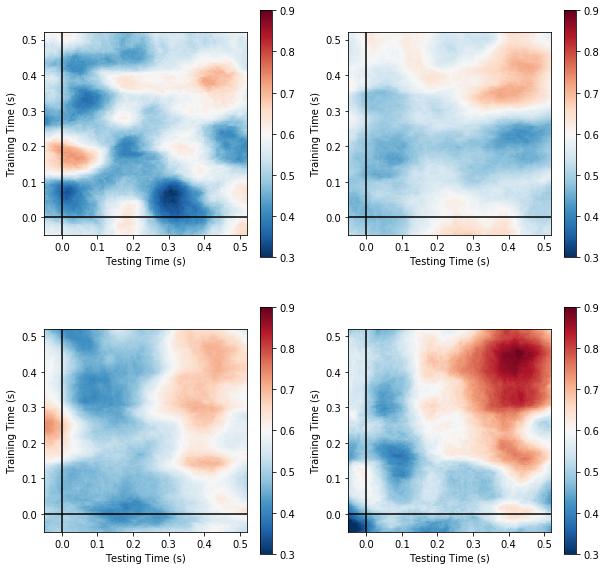

In [33]:
fig, (ax) = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

for i in range(4):
    curax = ax.ravel()[i]
    
    im = curax.matshow(allscores.mean(axis=1)[i], cmap='RdBu_r', vmin=0.3,vmax=0.9,origin='lower',
                        extent=timepoints)
    curax.axhline(0., color='k')
    curax.axvline(0., color='k')
    curax.xaxis.set_ticks_position('bottom')
    curax.set_xlabel('Testing Time (s)')
    curax.set_ylabel('Training Time (s)')
    plt.colorbar(im, ax=curax)

Analysis of all subjects
--

Formal structure

In [10]:
temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']

tmin = -0.05
tmax = 0.52
ncv  = 2

#tmin = 0.25
#tmax = 0.40
#ncv  = 2

allscores_formal = []
allproba_formal = []

allU_formal = []
allpval_formal= []

listofsubj = [allcontrols,allpatients]

savenpz = True
overwrite = False

for kk,group in enumerate(['probands','patients']):
    
    curlist = listofsubj[kk]
    
    for matfile in curlist:
        curfile = os.path.join(datadir,group,matfile)
        subjid = curfile[-8:-4]
        print(subjid)
        
        if os.path.isfile(os.path.join(resultdir,"190201_beta_%s_formal_conditionwise.npz" % subjid)) and (not overwrite):
            print("Subject already processed - continue...")
            continue

        allscores,allU,allpvals,allproba,timepoints = tf_tests(curfile,average=4,metric='roc_auc',
         tmin=tmin,tmax=tmax,ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)
        
       

        if savenpz:
            np.savez_compressed(os.path.join(resultdir,"190201_beta_%s_formal_conditionwise.npz" % subjid),
                                scores=allscores,
                                proba = allproba,
                                U = allU,
                                pval=allpvals)

14k1
Subject already processed - continue...
07k1
Subject already processed - continue...
08k1
Subject already processed - continue...
16k1
Subject already processed - continue...
06k1
Subject already processed - continue...
09k1
Subject already processed - continue...
12k1
Subject already processed - continue...
18k1
Subject already processed - continue...
20k1
Subject already processed - continue...
15k1
Subject already processed - continue...
11k1
Subject already processed - continue...
03k1
Subject already processed - continue...
05k1
Subject already processed - continue...
02k1
Subject already processed - continue...
17k1
Subject already processed - continue...
01k1
Subject already processed - continue...
10k1
Subject already processed - continue...
19k1
Subject already processed - continue...
04k1
Subject already processed - continue...
13k1
Subject already processed - continue...
14c1
Subject already processed - continue...
06c1
Subject already processed - continue...
04c1
Subje

[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
07c2
Subject : 07c2 
Averaging 4 consecutive trials for each condition
(241, 61, 425) (71, 61, 425) (239, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (17, 61, 425) (59, 61, 425) (17, 61, 425)
---
153 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
153 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[              

[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                       

[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
07c1
Subject : 07c1 
Averaging 4 consecu

[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                       

[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                       

[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
06c3
Subject : 06c3 
Averaging 4 consecutive trials for each condition
(228, 61, 425) (66, 61, 425) (228, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(57, 61, 425) (16, 61, 425) (57, 61, 425) (17, 61, 425)
---
147 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
147 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[              

0 bad epochs dropped
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                  

[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Fitting GeneralizingEstimato
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                        ]   0.00% Scoring GeneralizingEstimato
[                                        ]   0.00% Transforming GeneralizingEst
[                                       

In [11]:
resultdir

'/home/nfarrugi/localdata/mpi_pd_cueing/results_beta/'